# Usage Journey Analysis Report: Phase-1

## 1. Introduction

### 1.1 Objective of the Analysis

Understand patterns and user segments associated with customer "usage journey" based on variability of usage and average power consumption.

### 1.2 Key Questions to Answer

1. **How many days does it take for a customer to get to each key moment? from activation and first usage**
2. **Is there a difference between purchase date vs. first usage date in terms of long term usage patterns, i.e. "If you're slow to start using it you end up using it rarely"**
3. **Technically is it feasible/easy/hard to do timeline playback, i.e. what would've happened to people each day previously?**


4. **How stable are the usage patterns over time?**


### 1.3 Brief Description of the Dataset used


### 1.4 Scope and limitations




## 2. Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import logging
import sshtunnel
import os
import matplotlib.pyplot as plt
import pymysql
import paramiko
from dotenv import load_dotenv
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

/opt/anaconda3/lib/python3.12/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


## 3. Data Loading

### 3.1 Database Utils Setup

In [2]:
env_path=os.path.join('.keys', 'keys.env')

if os.path.exists(env_path):
    load_dotenv(env_path)


ssh_host = os.getenv('EC2_IP')
ssh_username = os.getenv('EC2_USER')
ssh_key = os.path.join('.keys','ecook-app-stage-live.pem')


db_host = os.getenv('RDS_HOST')
db_username = os.getenv('RDS_USER')
db_password = os.getenv('RDS_PASSWORD')
db_name = os.getenv('DB_NAME')


'''
with sshtunnel.SSHTunnelForwarder(
    (ssh_host, 22), 
    ssh_username=ssh_username, 
    ssh_pkey=ssh_key, 
    remote_bind_address=(db_host, 3306)
) as tunnel:
    print("Connecton Established", tunnel)
    
    db = pymysql.connect(
        host='127.0.0.1',
        user=db_username,
        passwd=db_password,
        db=db_name,
        port=tunnel.local_bind_port
    )
    with db.cursor() as cur:
        cur.execute("select * from tbl_accounts")
        for r in cur:
             print(r)
    db.close()
'''


def open_ssh_tunnel(verbose=False):
    if verbose:
        sshtunnel.DEFAULT_LOGLEVEL = logging.DEBUG
    global tunnel
    tunnel = sshtunnel.SSHTunnelForwarder(
        (ssh_host, 22),
        ssh_username = ssh_username,
        ssh_pkey = ssh_key,
        remote_bind_address=(db_host, 3306)
    )
    tunnel.start()


def mysql_connect():
    global connection 
    connection = pymysql.connect(
        host='localhost',
        user=db_username,
        passwd=db_password,
        db=db_name,
        port=tunnel.local_bind_port
    )


def run_query(sql):
    return pd.read_sql_query(sql, connection)

def mysql_disconnect():

    connection.close()

def close_ssh_tunnel():
    tunnel.close

In [ ]:
open_ssh_tunnel()
mysql_connect()

### 3.2 Data Loading

In [4]:
query = """
    select u.unit_number, u.calendar_date, u.daily_power_consumption, a.registration_date_utc from tbl_daily_compiled_usage_data u
    join tbl_accounts a on a.account_number = u.unit_number
    where a.country = 'Bangladesh'
    and a.account_status IN ('ENABLED', 'UNLOCKED')
    and u.daily_power_consumption is not null;
    """

In [10]:
df = pd.read_csv('./test.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

### 3.3 Dataset Overview

In [11]:
df.head(3)

unit_number calendar_date  daily_power_consumption     country
0    134644111    2024-03-01                     0.10  Bangladesh
1    134644111    2024-03-02                     0.68  Bangladesh
2    134644111    2024-03-03                     3.46  Bangladesh

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1943821 entries, 0 to 1943820
Data columns (total 4 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   unit_number              int64  
 1   calendar_date            object 
 2   daily_power_consumption  float64
 3   country                  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 59.3+ MB


In [13]:
df.describe()

unit_number  daily_power_consumption
count  1.943821e+06             1.943821e+06
mean   3.307404e+08             1.200664e+00
std    1.448385e+08             1.761502e+00
min    6.906995e+07             0.000000e+00
25%    2.488352e+08             0.000000e+00
50%    2.635454e+08             3.300000e-01
75%    4.012098e+08             1.920000e+00
max    9.289365e+08             6.923000e+01

### 3.4 Dataset Preprocessing

In [14]:
df['calendar_date'] = pd.to_datetime(df['calendar_date'])
df = df.sort_values(by=['unit_number', 'calendar_date'])

In [24]:
mean_df = df.groupby(['unit_number'])['daily_power_consumption'].mean().reset_index()

In [25]:
mean_df.head(3)

unit_number  daily_power_consumption
0     69069953                 0.658846
1     69070654                 1.187298
2     69070951                 0.187467

### 3.5 Defining bounds

ZERO_USER = 0
VERY_LOW_USER = 0.5
LOW_USER = 1.5
MODERATE_USER = 2.0
HIGH_USER = 3.0

In [26]:
ZERO_USER = 0
LOW_USER = 0.5
MODERATE_USER = 1.5
HIGH_USER = 2.0

In [108]:
ZERO_USER = 0
VERY_LOW_USER = 0.5
LOW_USER = 1.5
MODERATE_USER = 2.0
HIGH_USER = 3.0

In [109]:
def classify_user(consumption):
    if consumption <= ZERO_USER:
        return 'Zero User'
    elif consumption <= LOW_USER:
        return 'Low User'
    elif consumption <= MODERATE_USER:
        return 'Moderate User'
    elif consumption <= HIGH_USER:
        return 'High User'
    else:
        return 'Very High User'

In [110]:
mean_df['user_category'] = mean_df['daily_power_consumption'].apply(classify_user)

## 4. Analysis

### 4.1 User Segments

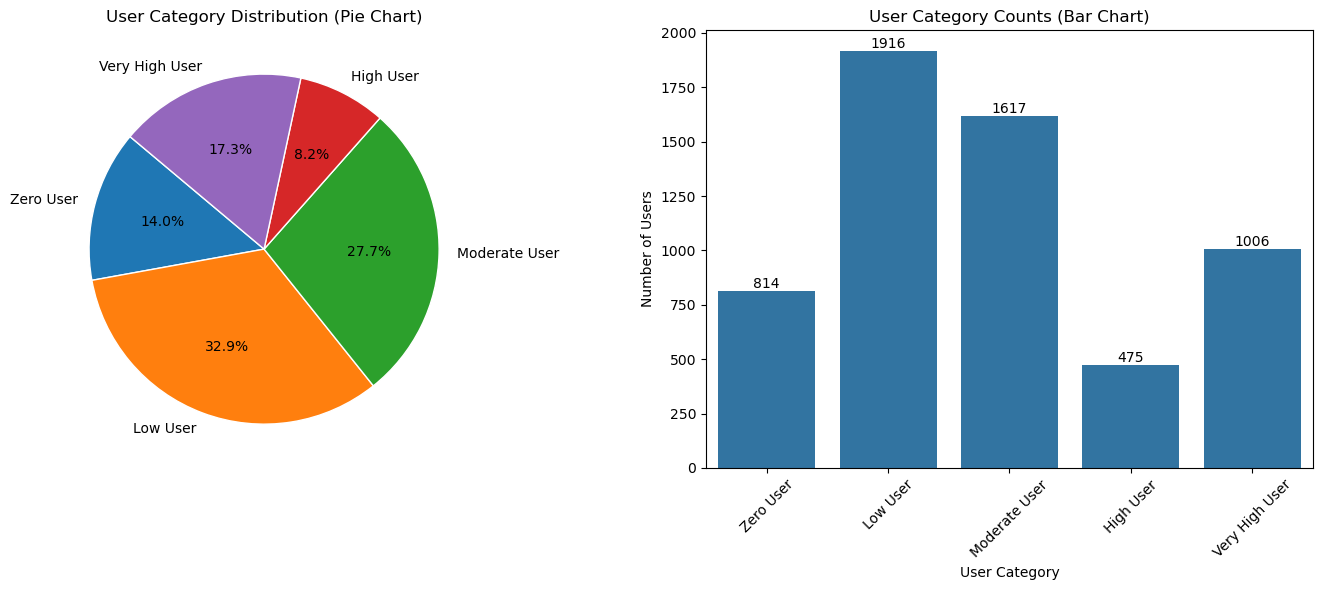

In [34]:
user_order = ['Zero User', 'Low User', 'Moderate User', 'High User', 'Very High User']

mean_df['user_category'] = pd.Categorical(mean_df['user_category'], categories=user_order, ordered=True)

category_counts = mean_df['user_category'].value_counts().loc[user_order]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'white'}
)
axes[0].set_title('User Category Distribution (Pie Chart)')

sns.barplot(
    x=category_counts.index,
    y=category_counts.values,
    ax=axes[1],
    order=user_order 
)
axes[1].set_title('User Category Counts (Bar Chart)')
axes[1].set_xlabel('User Category')
axes[1].set_ylabel('Number of Users')
axes[1].bar_label(axes[1].containers[0])  

axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 4.2 Cluster Journey overtime

In [39]:
def cluster_journey_overtime(user):
    user_df = df[df['unit_number'] == user].copy()

    user_df['month'] = user_df['calendar_date'].dt.to_period('M')

    monthly_behavior = user_df.groupby('month')['daily_power_consumption'].agg(['mean', 'std']).reset_index()
    monthly_behavior = monthly_behavior.fillna(0)

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(monthly_behavior[['mean', 'std']])

    kmeans = KMeans(n_clusters=3, random_state=42)
    monthly_behavior['cluster'] = kmeans.fit_predict(features_scaled)

    fig = px.scatter(
        monthly_behavior,
        x='mean',
        y='std',
        color='cluster',
        text=monthly_behavior['month'].astype(str),
        title=f'User {user}: Cluster Journey Over Time'
    )

    fig.update_traces(textposition='top center')
    fig.update_layout(
        xaxis_title='Average Daily Consumption (kWh)',
        yaxis_title='Usage Variability (kWh)',
        width=900,
        height=600,
        showlegend=True
    )

    fig.add_trace(
        go.Scatter(
            x=monthly_behavior['mean'],
            y=monthly_behavior['std'],
            mode='lines',
            line=dict(color='black', dash='dash'),
            showlegend=False
        )
    )

    fig.show()

#### 4.2.1 Zero Users

In [53]:
cluster_journey_overtime(mean_df[mean_df['user_category'] == 'Zero User']['unit_number'].sample(1).iloc[0])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: ConvergenceWarning:

Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.



#### 4.2.2 Low Users

In [54]:
cluster_journey_overtime(mean_df[mean_df['user_category'] == 'Low User']['unit_number'].sample(1).iloc[0])

#### 4.2.3 Moderate Users

In [55]:
cluster_journey_overtime(mean_df[mean_df['user_category'] == 'Moderate User']['unit_number'].sample(1).iloc[0])

#### 4.2.4 High Users

In [56]:
cluster_journey_overtime(mean_df[mean_df['user_category'] == 'High User']['unit_number'].sample(1).iloc[0])

#### 4.2.5 Very High Users

In [57]:
cluster_journey_overtime(mean_df[mean_df['user_category'] == 'Very High User']['unit_number'].sample(1).iloc[0])

### 4.3 Dynamic Population Cluster Over Time

In [58]:
# Preprocess input data
df['calendar_date'] = pd.to_datetime(df['calendar_date'])
df['month'] = df['calendar_date'].dt.to_period('M')

usage_colors = {
    'Low Users': 'green',
    'Moderate Users': 'blue',
    'High Users': 'red'
}

all_frames = []
transition_records = []

# Dynamic clustering per month
months = sorted(df['month'].unique())
prev_assignments = {}

for month in months:
    month_df = df[df['month'] == month]
    summary = month_df.groupby('unit_number')['daily_power_consumption'].agg(['mean', 'std', 'max', 'min']).reset_index()
    summary = summary.fillna(0)
    summary['month'] = str(month)

    if len(summary) < 3:
        continue

    # Clustering
    scaler = StandardScaler()
    scaled = scaler.fit_transform(summary[['mean', 'std', 'max', 'min']])
    kmeans = KMeans(n_clusters=3, random_state=42)
    summary['cluster'] = kmeans.fit_predict(scaled)

    # Label clusters by mean
    centroids = summary.groupby('cluster')['mean'].mean().sort_values().reset_index()
    label_map = {
        centroids.loc[0, 'cluster']: 'Low Users',
        centroids.loc[1, 'cluster']: 'Moderate Users',
        centroids.loc[2, 'cluster']: 'High Users'
    }
    summary['usage_level'] = summary['cluster'].map(label_map)
    summary['color'] = summary['usage_level'].map(usage_colors)

    # Track transitions
    current_assignments = dict(zip(summary['unit_number'], summary['usage_level']))
    if prev_assignments:
        for uid, new_level in current_assignments.items():
            old_level = prev_assignments.get(uid, None)
            if old_level:
                transition_records.append({
                    'unit_number': uid,
                    'from_month': str(months[months.index(month) - 1]),
                    'to_month': str(month),
                    'from_cluster': old_level,
                    'to_cluster': new_level
                })
    prev_assignments = current_assignments

    # Real boundary shapes: ellipses around each cluster
    cluster_shapes = []
    grouped = summary.groupby(['cluster', 'usage_level'])
    for (cl, label), grp in grouped:
        mean_x = grp['mean'].mean()
        mean_y = grp['std'].mean()
        std_x = grp['mean'].std()
        std_y = grp['std'].std()
        cluster_shapes.append({
            'label': label,
            'x0': mean_x - std_x * 2,
            'x1': mean_x + std_x * 2,
            'y0': mean_y - std_y * 2,
            'y1': mean_y + std_y * 2,
            'color': usage_colors[label]
        })

    all_frames.append((str(month), summary, cluster_shapes))

# Create initial figure
initial_month, initial_data, initial_shapes = all_frames[0]
fig = go.Figure()

# Initial scatter
fig.add_trace(go.Scatter(
    x=initial_data['mean'],
    y=initial_data['std'],
    mode='markers',
    marker=dict(color=initial_data['color'], size=8),
    text=initial_data['unit_number'],
    hovertemplate='Unit: %{text}<br>Mean: %{x:.2f}<br>Std: %{y:.2f}'
))

# Initial shapes
for shape in initial_shapes:
    fig.add_shape(
        type="rect",
        x0=shape['x0'], x1=shape['x1'],
        y0=shape['y0'], y1=shape['y1'],
        fillcolor=shape['color'],
        opacity=0.15,
        line=dict(color=shape['color']),
        layer="below"
    )

# Add animation frames
frames = []
for month, data, shapes in all_frames:
    scatter = go.Scatter(
        x=data['mean'],
        y=data['std'],
        mode='markers',
        marker=dict(color=data['color'], size=8),
        text=data['unit_number'],
        hovertemplate='Unit: %{text}<br>Mean: %{x:.2f}<br>Std: %{y:.2f}'
    )
    frame_shapes = [
        dict(
            type="rect",
            x0=s['x0'], x1=s['x1'],
            y0=s['y0'], y1=s['y1'],
            fillcolor=s['color'],
            opacity=0.15,
            line=dict(color=s['color']),
            layer="below"
        ) for s in shapes
    ]
    frames.append(go.Frame(data=[scatter], name=month, layout=dict(shapes=frame_shapes)))

fig.frames = frames

# Add layout and controls
fig.update_layout(
    title="Dynamic Clustering with Real Boundaries and Transition Tracking",
    xaxis_title="Average Consumption (kWh)",
    yaxis_title="Usage Variability (kWh)",
    updatemenus=[{
        "type": "buttons",
        "buttons": [
            {"label": "Play", "method": "animate", "args": [None, {"frame": {"duration": 600, "redraw": True}, "fromcurrent": True}]},
            {"label": "Pause", "method": "animate", "args": [[None], {"frame": {"duration": 0}, "mode": "immediate"}]}
        ]
    }],
    sliders=[{
        "steps": [{
            "method": "animate",
            "label": month,
            "args": [[month], {"frame": {"duration": 0}, "mode": "immediate"}]
        } for month, _, _ in all_frames]
    }]
)

fig.show()

### 4.4 Average Population Cluster Level Over Time

In [60]:
df['month'] = df['calendar_date'].dt.to_period('M')
monthly_stats = df.groupby(['unit_number', 'month'])['daily_power_consumption'].agg(['mean', 'std', 'max', 'min']).reset_index()
monthly_stats = monthly_stats.fillna(0)

avg_cluster_levels = []
cluster_labels = ['Low Users', 'Moderate Users', 'High Users']
label_to_level = {'Low Users': 0, 'Moderate Users': 1, 'High Users': 2}
months = sorted(monthly_stats['month'].unique())

for month in months:
    month_data = monthly_stats[monthly_stats['month'] == month]
    if len(month_data) < 3:
        continue

    scaler = StandardScaler()
    scaled = scaler.fit_transform(month_data[['mean', 'std', 'max', 'min']])
    kmeans = KMeans(n_clusters=3, random_state=42)
    month_data = month_data.copy()
    month_data['cluster'] = kmeans.fit_predict(scaled)

    centroids = month_data.groupby('cluster')['mean'].mean().sort_values().reset_index()
    cluster_map = {
        centroids.loc[0, 'cluster']: 'Low Users',
        centroids.loc[1, 'cluster']: 'Moderate Users',
        centroids.loc[2, 'cluster']: 'High Users'
    }

    month_data['usage_level'] = month_data['cluster'].map(cluster_map)
    month_data['level_num'] = month_data['usage_level'].map(label_to_level)

    avg_level = month_data['level_num'].mean()
    avg_cluster_levels.append({
        'month_str': str(month),
        'avg_level': avg_level
    })

avg_df = pd.DataFrame(avg_cluster_levels)

import plotly.express as px
fig = px.line(
    avg_df,
    x='month_str',
    y='avg_level',
    markers=True,
    title='Average User Cluster Level Over Time'
)

fig.update_layout(
    yaxis_title='Average Cluster Level',
    xaxis_title='Month',
    yaxis=dict(
        tickmode='array',
        tickvals=[0, 1, 2],
        ticktext=['Low Users', 'Moderate Users', 'High Users']
    )
)

fig.show()

### 4.5 Proportion of Users in User Segments Defined

In [62]:
df['month'] = df['calendar_date'].dt.to_period('M')

monthly_stats = df.groupby(['unit_number', 'month'])['daily_power_consumption'].agg(['mean', 'std', 'max', 'min']).reset_index()
monthly_stats = monthly_stats.fillna(0)

def classify_fixed(mean_val):
    if mean_val <= 0:
        return 'Zero User'
    elif mean_val <= 0.5:
        return 'Low User'
    elif mean_val <= 1.5:
        return 'Moderate User'
    elif mean_val <= 2.0:
        return 'High User'
    else:
        return 'Very High User'

monthly_stats['fixed_usage_level'] = monthly_stats['mean'].apply(classify_fixed)

fixed_cluster_labels = ['Zero User', 'Low User', 'Moderate User', 'High User', 'Very High User']

frames = []

months = sorted(monthly_stats['month'].unique())
for month in months:
    month_data = monthly_stats[monthly_stats['month'] == month]
    level_counts = month_data['fixed_usage_level'].value_counts(normalize=True).reindex(fixed_cluster_labels, fill_value=0)
    
    for label in fixed_cluster_labels:
        frames.append({
            'month_str': str(month),
            'fixed_usage_level': label,
            'proportion': level_counts[label]
        })

plot_df = pd.DataFrame(frames)

fig = px.line(
    plot_df,
    x='month_str',
    y='proportion',
    color='fixed_usage_level',
    markers=True,
    title='Proportion of Users by Fixed Usage Categories Over Time'
)

fig.update_layout(
    yaxis_title='Proportion of Users',
    xaxis_title='Month',
    yaxis=dict(tickformat=".0%"),
    width=1000,
    height=600,
    legend_title='Usage Level',
    plot_bgcolor='white',
    font=dict(family='Arial', size=14, color='black')
)

fig.update_traces(marker=dict(size=8))

fig.show()

### 4.6 User Segment Transitions

#### 4.6.1 User Transition Count

In [68]:
# Step 1: Prepare monthly stats
df['month'] = df['calendar_date'].dt.to_period('M')

monthly_stats = df.groupby(['unit_number', 'month'])['daily_power_consumption'].agg(['mean', 'std', 'max', 'min']).reset_index()
monthly_stats = monthly_stats.fillna(0)

# Step 2: Classify into fixed usage levels
def classify_fixed(mean_val):
    if mean_val <= 0:
        return 'Zero User'
    elif mean_val <= 0.5:
        return 'Low User'
    elif mean_val <= 1.5:
        return 'Moderate User'
    elif mean_val <= 2.0:
        return 'High User'
    else:
        return 'Very High User'

monthly_stats['usage_level'] = monthly_stats['mean'].apply(classify_fixed)
monthly_stats['month_str'] = monthly_stats['month'].astype(str)

# Step 3: Prepare user journey
journey_df = monthly_stats[['unit_number', 'month_str', 'usage_level']].copy()
journey_df = journey_df.sort_values(['unit_number', 'month_str'])

# Step 4: Calculate transitions between months (raw counts)
timeline_transitions = []
months = sorted(journey_df['month_str'].unique())

for i in range(len(months) - 1):
    month = months[i]
    next_month = months[i + 1]

    current_df = journey_df[journey_df['month_str'] == month]
    next_df = journey_df[journey_df['month_str'] == next_month]

    merged = pd.merge(current_df, next_df, on='unit_number', suffixes=('_curr', '_next'))

    transition_grp = merged.groupby(['usage_level_curr', 'usage_level_next']).size().reset_index(name='count')
    transition_grp['month_str'] = month

    timeline_transitions.append(transition_grp)

timeline_df = pd.concat(timeline_transitions, ignore_index=True)

# Step 5: Pivot transitions
pivot_df = timeline_df.pivot_table(
    index='month_str',
    columns=['usage_level_curr', 'usage_level_next'],
    values='count',
    fill_value=0
)

pivot_df.columns = [f"{frm} → {to}" for frm, to in pivot_df.columns]
pivot_df = pivot_df.sort_index()

# Step 6: Reshape for plotting
pivot_df_reset = pivot_df.reset_index().melt(
    id_vars='month_str',
    var_name='transition',
    value_name='count'
)

# Step 7: ----> New: Classify transitions (Good, Moderate, Bad)
def classify_transition(transition):
    frm, to = transition.split(' → ')
    if to in ['High User', 'Very High User']:
        return 'Good'
    elif to == 'Moderate User':
        return 'Moderate'
    else:
        return 'Bad'

pivot_df_reset['transition_type'] = pivot_df_reset['transition'].apply(classify_transition)

# Assign colors manually
transition_colors = {
    'Good': 'green',
    'Moderate': 'orange',
    'Bad': 'red'
}

# Create a mapping for each transition individually
transition_color_map = {}
for idx, row in pivot_df_reset[['transition', 'transition_type']].drop_duplicates().iterrows():
    transition_color_map[row['transition']] = transition_colors[row['transition_type']]

# Step 8: Plot with custom colors
fig = px.area(
    pivot_df_reset,
    x='month_str',
    y='count',
    color='transition',
    title='Timeline of User Transitions Between Fixed Usage Levels (Colored by Transition Quality)',
    labels={
        'month_str': 'Month',
        'count': 'User Count',
        'transition': 'Transition Type'
    },
    color_discrete_map=transition_color_map
)

fig.update_layout(
    xaxis_title='Month',
    yaxis_title='User Count',
    legend_title='Transition Type',
    hovermode='x unified',
    width=1100,
    height=650,
    font=dict(family='Arial', size=14, color='black'),
    plot_bgcolor='white',
    legend_itemclick='toggleothers', 
    legend_itemdoubleclick='toggle'
)

fig.update_traces(marker=dict(size=8))

fig.show()

#### 4.6.2 User Transitions Normalized

In [69]:
# Step 1: Prepare monthly stats
df['month'] = df['calendar_date'].dt.to_period('M')

monthly_stats = df.groupby(['unit_number', 'month'])['daily_power_consumption'].agg(['mean', 'std', 'max', 'min']).reset_index()
monthly_stats = monthly_stats.fillna(0)

# Step 2: Assign fixed usage levels
def classify_fixed(mean_val):
    if mean_val <= 0:
        return 'Zero User'
    elif mean_val <= 0.5:
        return 'Low User'
    elif mean_val <= 1.5:
        return 'Moderate User'
    elif mean_val <= 2.0:
        return 'High User'
    else:
        return 'Very High User'

monthly_stats['usage_level'] = monthly_stats['mean'].apply(classify_fixed)
monthly_stats['month_str'] = monthly_stats['month'].astype(str)

# Step 3: Prepare journey dataframe
journey_df = monthly_stats[['unit_number', 'month_str', 'usage_level']].copy()
journey_df = journey_df.sort_values(['unit_number', 'month_str'])

# Step 4: Calculate transitions between months (normalized)
timeline_transitions = []
months = sorted(journey_df['month_str'].unique())

for i in range(len(months) - 1):
    month = months[i]
    next_month = months[i + 1]

    current_df = journey_df[journey_df['month_str'] == month]
    next_df = journey_df[journey_df['month_str'] == next_month]

    merged = pd.merge(current_df, next_df, on='unit_number', suffixes=('_curr', '_next'))

    total_users = len(merged)

    transition_grp = merged.groupby(['usage_level_curr', 'usage_level_next']).size().reset_index(name='count')
    transition_grp['proportion'] = transition_grp['count'] / total_users
    transition_grp['month_str'] = month

    timeline_transitions.append(transition_grp)

# Step 5: Pivot and prepare for plotting
timeline_df = pd.concat(timeline_transitions, ignore_index=True)

pivot_df = timeline_df.pivot_table(
    index='month_str',
    columns=['usage_level_curr', 'usage_level_next'],
    values='proportion',
    fill_value=0
)

pivot_df.columns = [f"{frm} → {to}" for frm, to in pivot_df.columns]
pivot_df = pivot_df.sort_index()

# Step 6: Reshape and classify transitions
pivot_df_reset = pivot_df.reset_index().melt(
    id_vars='month_str',
    var_name='transition',
    value_name='proportion'
)

# ----> New: Classify transitions as Good, Moderate, or Bad
def classify_transition(transition):
    frm, to = transition.split(' → ')
    
    if to in ['High User', 'Very High User']:
        return 'Good'
    elif to == 'Moderate User':
        return 'Moderate'
    else:
        return 'Bad'

pivot_df_reset['transition_type'] = pivot_df_reset['transition'].apply(classify_transition)

# Assign colors manually
transition_colors = {
    'Good': 'green',
    'Moderate': 'orange',
    'Bad': 'red'
}

# Create a mapping for each transition individually
transition_color_map = {}
for idx, row in pivot_df_reset[['transition', 'transition_type']].drop_duplicates().iterrows():
    transition_color_map[row['transition']] = transition_colors[row['transition_type']]

# Step 7: Plot with custom colors
fig = px.area(
    pivot_df_reset,
    x='month_str',
    y='proportion',
    color='transition',
    title='Normalized Timeline of User Transitions with Transition Quality Coloring',
    labels={
        'month_str': 'Month',
        'proportion': 'Proportion of Users',
        'transition': 'Transition Type'
    },
    color_discrete_map=transition_color_map
)

fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Proportion of Users',
    yaxis_tickformat=".0%",
    legend_title='Transition Type',
    hovermode='x unified',
    width=1100,
    height=650,
    font=dict(family='Arial', size=14, color='black'),
    plot_bgcolor='white',
    legend_itemclick='toggleothers', 
    legend_itemdoubleclick='toggle'
)

fig.update_traces(marker=dict(size=8))

fig.show()

#### 4.6.3 User Transition Based on Initial Group

In [111]:
from plotly.subplots import make_subplots

df['month'] = df['calendar_date'].dt.to_period('M')

monthly_stats = df.groupby(['unit_number', 'month'])['daily_power_consumption'].agg(['mean']).reset_index()
monthly_stats = monthly_stats.fillna(0)

def classify_fixed(mean_val):
    if mean_val <= 0:
        return 'Zero User'
    elif mean_val <= VERY_LOW_USER:
        return 'Very Low User'
    elif mean_val <= LOW_USER:
        return 'Low User'
    elif mean_val <= MODERATE_USER:
        return 'Moderate User'
    elif mean_val <= HIGH_USER:
        return 'High User'
    else:
        return 'Very High User'

monthly_stats['usage_level'] = monthly_stats['mean'].apply(classify_fixed)
monthly_stats['month_str'] = monthly_stats['month'].astype(str)

first_usage = monthly_stats.sort_values(['unit_number', 'month']).groupby('unit_number').first().reset_index()
first_usage = first_usage[['unit_number', 'usage_level']]
first_usage.columns = ['unit_number', 'initial_usage_level']

journey_df = pd.merge(monthly_stats, first_usage, on='unit_number', how='left')

cohort_df = journey_df.groupby(['initial_usage_level', 'month_str', 'usage_level']).size().reset_index(name='user_count')

initial_groups = cohort_df['initial_usage_level'].unique()
n_rows = len(initial_groups)

fig = make_subplots(
    rows=n_rows,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=[f"Cohort: {group}" for group in initial_groups]
)

color_map = {
    'Zero User': 'lightgray',
    'Low User': 'red',
    'Moderate User': 'orange',
    'High User': 'blue',
    'Very High User': 'green'
}

for idx, group in enumerate(initial_groups, start=1):
    sub_df = cohort_df[cohort_df['initial_usage_level'] == group]

    for usage_level in sub_df['usage_level'].unique():
        usage_data = sub_df[sub_df['usage_level'] == usage_level]

        fig.add_trace(
            go.Scatter(
                x=usage_data['month_str'],
                y=usage_data['user_count'],
                stackgroup='one',
                name=usage_level,
                legendgroup=usage_level,
                showlegend=True if idx == 1 else False,  # Only show legend once
                line=dict(width=0.5),
                fillcolor=color_map.get(usage_level, 'gray')
            ),
            row=idx,
            col=1
        )

fig.update_layout(
    height=300 * n_rows,
    width=1000,
    title_text="Cohort Chart: User Group Transitions Over Time",
    showlegend=True,
    font=dict(family='Arial', size=14),
    plot_bgcolor='white',
    hovermode='x unified'
)

fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Number of Users")

fig.show()

### 4.7 User Journey Timeline for User

In [70]:
def user_journey(unit):
    df['month'] = df['calendar_date'].dt.to_period('M')
    user_counts = df.groupby('unit_number')['month'].nunique()

    if user_counts.get(unit, 0) <= 2:
        print(f"User {unit} does not have enough months of data.")
        return

    user_df = df[df['unit_number'] == unit].copy()
    user_df = user_df.groupby('month')['daily_power_consumption'].agg(['mean', 'std', 'max', 'min']).reset_index()
    user_df = user_df.fillna(0)

    def classify_fixed(mean_val):
        if mean_val <= 0:
            return 'Zero User'
        elif mean_val <= 0.5:
            return 'Low User'
        elif mean_val <= 1.5:
            return 'Moderate User'
        elif mean_val <= 2.0:
            return 'High User'
        else:
            return 'Very High User'

    user_df['usage_level'] = user_df['mean'].apply(classify_fixed)
    user_df['month_str'] = user_df['month'].astype(str)

    fixed_order = ['Zero User', 'Low User', 'Moderate User', 'High User', 'Very High User']

    fig = px.line(
        user_df,
        x='month_str',
        y='usage_level',
        markers=True,
        title=f'Usage Journey of User {unit}',
        category_orders={'usage_level': fixed_order}
    )

    fig.update_layout(
        yaxis_title='Usage Category',
        xaxis_title='Month',
        yaxis=dict(categoryorder='array', categoryarray=fixed_order),
        width=900,
        height=500,
        plot_bgcolor='white',
        font=dict(family='Arial', size=14)
    )

    fig.show()

#### 4.7.1 Zero User

In [75]:
user_journey(mean_df[mean_df['user_category'] == 'Zero User']['unit_number'].sample(1).iloc[0])

#### 4.7.2 Low User

In [76]:
user_journey(mean_df[mean_df['user_category'] == 'Low User']['unit_number'].sample(1).iloc[0])

#### 4.7.3 Moderate User

In [77]:
user_journey(mean_df[mean_df['user_category'] == 'Moderate User']['unit_number'].sample(1).iloc[0])

#### 4.7.4 High User

In [78]:
user_journey(mean_df[mean_df['user_category'] == 'High User']['unit_number'].sample(1).iloc[0])

#### 4.7.5 Very High User

In [80]:
user_journey(mean_df[mean_df['user_category'] == 'Very High User']['unit_number'].sample(1).iloc[0])

### 4.8 Cohort Charts

In [ ]:
df['month'] = df['calendar_date'].dt.to_period('M')

monthly_stats = df.groupby(['unit_number', 'month'])['daily_power_consumption'].agg(['mean']).reset_index()
monthly_stats = monthly_stats.fillna(0)

def classify_fixed(mean_val):
    if mean_val <= 0:
        return 'Zero User'
    elif mean_val <= 0.5:
        return 'Low User'
    elif mean_val <= 1.5:
        return 'Moderate User'
    elif mean_val <= 2.0:
        return 'High User'
    else:
        return 'Very High User'

monthly_stats['usage_level'] = monthly_stats['mean'].apply(classify_fixed)
monthly_stats['month_str'] = monthly_stats['month'].astype(str)

high_users = monthly_stats[monthly_stats['usage_level'].isin(['High User', 'Very High User'])]

first_high_month = high_users.groupby('unit_number')['month'].min().reset_index()
first_high_month.columns = ['unit_number', 'first_high_month']

user_journey = pd.merge(monthly_stats, first_high_month, on='unit_number', how='inner')

user_journey = user_journey[user_journey['month'] >= user_journey['first_high_month']]

user_journey['cohort_month'] = user_journey['first_high_month'].astype(str)
user_journey['period'] = (user_journey['month'] - user_journey['first_high_month']).apply(lambda x: x.n)

user_journey['retained'] = user_journey['usage_level'].isin(['High User', 'Very High User']).astype(int)

cohort_pivot = user_journey.pivot_table(
    index='cohort_month',
    columns='period',
    values='retained',
    aggfunc='mean'
)

cohort_pivot = cohort_pivot.fillna(0)

fig = px.imshow(
    cohort_pivot,
    labels=dict(x="Months Since Becoming High User", y="Cohort Start Month", color="Retention Rate"),
    text_auto=True,
    color_continuous_scale='Greens',
    title='Retention of High/Very High Users Over Time'
)

fig.update_layout(
    width=1000,
    height=600,
    font=dict(family='Arial', size=14),
    xaxis_title='Months Since Becoming High/Very High',
    yaxis_title='Cohort Month',
    coloraxis_colorbar=dict(
        tickformat=".0%",
        title="Retention Rate"
    )
)

fig.show()

Add average daily usage here instead of retention rate

Add counts in the above plot

Change gradient to green yellow red

### 4.9 Rentention Of Users

In [ ]:
df['month'] = df['calendar_date'].dt.to_period('M')

monthly_stats = df.groupby(['unit_number', 'month'])['daily_power_consumption'].agg(['mean']).reset_index()
monthly_stats = monthly_stats.fillna(0)

def classify_fixed(mean_val):
    if mean_val <= 0:
        return 'Zero User'
    elif mean_val <= 0.5:
        return 'Low User'
    elif mean_val <= 1.5:
        return 'Moderate User'
    elif mean_val <= 2.0:
        return 'High User'
    else:
        return 'Very High User'

monthly_stats['usage_level'] = monthly_stats['mean'].apply(classify_fixed)
monthly_stats['month_str'] = monthly_stats['month'].astype(str)

high_users = monthly_stats[monthly_stats['usage_level'].isin(['High User', 'Very High User'])]

first_high_month = high_users.groupby('unit_number')['month'].min().reset_index()
first_high_month.columns = ['unit_number', 'first_high_month']

user_journey = pd.merge(monthly_stats, first_high_month, on='unit_number', how='inner')

user_journey = user_journey[user_journey['month'] >= user_journey['first_high_month']]

user_retention = user_journey.groupby('unit_number')['usage_level'].apply(
    lambda x: all(level in ['High User', 'Very High User'] for level in x)
).reset_index()

user_retention.columns = ['unit_number', 'retained']

total_users = len(user_retention)
retained_users = user_retention['retained'].sum()
retention_rate = retained_users / total_users

print(f"Total Users who became High/Very High: {total_users}")
print(f"Users who stayed High/Very High: {retained_users}")
print(f"Overall Retention Rate: {retention_rate:.2%}")


Total Users who became High/Very High: 2853
Users who stayed High/Very High: 953
Overall Retention Rate: 33.40%


In [90]:
labels = ['Retained (Stayed High/Very High)', 'Dropped (Fell Below High)']
values = [retained_users, total_users - retained_users]

fig_pie = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0)])

fig_pie.update_layout(
    title_text='Overall Retention of High/Very High Users (Pie Chart)',
    font=dict(family='Arial', size=14),
    width=600,
    height=500
)

fig_pie.show()

In [92]:
fig_funnel = go.Figure(go.Funnel(
    y=["Became High/Very High", "Stayed High/Very High"],
    x=[total_users, retained_users],
    textinfo="value+percent previous"
))

fig_funnel.update_layout(
    title='Retention Funnel for High/Very High Users',
    width=600,
    height=500,
    font=dict(family='Arial', size=14),
    plot_bgcolor='white'
)

fig_funnel.show()

Different versions for moderate, high and very high

funnel for new usage groups

In [95]:
very_high = mean_df[mean_df['user_category']=='Very High User']

In [97]:
hs = pd.read_csv('hubspot-data.csv')
hs.head(3)

unit_number product_variant family_members  \
0    134644111    eCook Double             4+   
1    134502210    eCook Double             4+   
2    134503218    eCook Single            1-4   

                      cooking_fuel payment_method upfront_or_monthly  \
0                      Natural Gas           Cash            Upfront   
1  Natural Gas;Electric Stove;Wood           Cash            Upfront   
2                             Wood           Cash            Upfront   

  product_condition   occupation    district     sub_district  
0               New  Private Job  Chattogram        Chandgaon  
1               New  Private Job   Narsingdi           Belabo  
2               New  Private Job   Joypurhat  Jaipurhat Sadar

In [98]:
merged_df = pd.merge(
    very_high,
    hs,
    on='unit_number',
    how='left'
)

In [100]:
merged_df.head(3)

unit_number  daily_power_consumption   user_category product_variant  \
0     69072858                 4.582095  Very High User    eCook Single   
1     69073559                 2.571120  Very High User    eCook Double   
2     69073658                 3.384895  Very High User    eCook Double   

  family_members    cooking_fuel payment_method upfront_or_monthly  \
0            NaN             NaN      27 months            Monthly   
1              4             NaN           Cash            Upfront   
2             4+  Electric Stove           Cash            Upfront   

  product_condition   occupation district sub_district  
0               NaN          NaN  Rangpur          NaN  
1       Refurbished  Private Job  Comilla       Meghna  
2       Refurbished     Business  Gazipur      Gazipur

In [101]:
family_data = merged_df[['unit_number', 'family_members']].dropna()

family_summary = family_data['family_members'].value_counts().reset_index()
family_summary.columns = ['family_members', 'user_count']

fig = px.bar(
    family_summary,
    x='family_members',
    y='user_count',
    title='Distribution of Family Members among Very High Users',
    labels={'family_members': 'Number of Family Members', 'user_count': 'Number of Users'},
    text='user_count'
)

fig.update_layout(
    width=800,
    height=500,
    font=dict(family='Arial', size=14),
    plot_bgcolor='white',
    xaxis_title='Family Members',
    yaxis_title='Number of Users',
    yaxis_tickformat='d'
)

fig.update_traces(
    marker_color='teal',
    textposition='outside'
)

fig.show()

stacked bar chart with family size

what is the percentage that stays very high

In [102]:
product_data = merged_df[['unit_number', 'product_variant']].dropna()

product_summary = product_data['product_variant'].value_counts().reset_index()
product_summary.columns = ['product_variant', 'user_count']

fig = px.pie(
    product_summary,
    names='product_variant',
    values='user_count',
    title='Distribution of Product Variants among Very High Users',
    hole=0,  
)

fig.update_traces(textposition='inside', textinfo='percent+label')

fig.update_layout(
    width=700,
    height=500,
    font=dict(family='Arial', size=14),
    plot_bgcolor='white'
)

fig.show()

what is the distribution for different user groups to be part of a particular product variant